In [1]:
from SnackTrackDataset import SnackTrackDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
import random
from SnackTrackBasicModel import BasicModel

### Training

Cell for participant split of database (Leave-One-Participant-Out)

In [ ]:
# Load metadata (example dataframe)
metadata_file = "/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/metadata.csv"  # Path to metadata file
metadata = pd.read_csv(metadata_file)

# Group by participant
participants = metadata['participant'].unique()

# Select one participant for validation
val_participant = random.choice(participants)  # Randomly select one participant
train_participants = [p for p in participants if p != val_participant]

# Create metadata subsets
train_metadata = metadata[metadata['participant'].isin(train_participants)]
val_metadata = metadata[metadata['participant'] == val_participant]

# Create datasets
train_dataset = SnackTrackDataset(train_metadata)
val_dataset = SnackTrackDataset(val_metadata)

train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Validation participant: {val_participant}")
print(f"Training participants: {train_participants}")

Cell for random split of dataset.

In [ ]:
# Dataset and DataLoader
metadata_file = "/Users/jannisdaiber/Documents/Repos/github/ProjectMedicalWearables/Database/metadata_balanced.csv"  # Path to metadata file
metadata = pd.read_csv(metadata_file)
dataset = SnackTrackDataset(metadata)

# Split into train and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

Training of the CNN using the defined DataLoaders.

In [ ]:
# Parameters
batch_size = 80
learning_rate = 0.001
num_epochs = 10

# Use GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Setup DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Initialize model, loss, optimizer
model = BasicModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

# lists used for calculating evaluation metrics
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
val_predictions = []
val_gt = []

for epoch in range(num_epochs):
    # perform training followed by validation
    for mode, loader, num_samples in [
        ("train", train_loader, train_size),
        ("val", val_loader, val_size)
    ]:
        # progress bar setup
        num_batches = int(ceil(num_samples / batch_size))
        pbar = tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train()
        else:
            model.eval()

        # initial values of the metrics (loss, accurracy)
        runningLoss = 0.
        correct_predictions = 0
        # total number of images that were processed
        total_samples = 0

        for spectrograms, labels in loader:
            # move tensors to the correct device
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            # forward step of model
            outputs = model(spectrograms)

            if mode == "val" and epoch == num_epochs - 1:
                val_predictions.append(outputs.argmax(dim=1))
                val_gt.append(labels)

            # loss calculation
            loss = criterion(outputs, labels)

            # calculate metrix for progress bar
            num_batch_samples = len(spectrograms)
            runningLoss += loss.item()
            correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += num_batch_samples

            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples,
                "accuracy": correct_predictions / total_samples
            })
            
            # if in train mode update weights
            if mode == "train":
                # backward step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
        epoch_loss = runningLoss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()

Using device: cpu


val epoch 9: 100%|██████████| 15/15 [00:25<00:00,  1.72s/it, loss=0.00427, accuracy=0.874]


Safe trained model.

In [ ]:
torch.save(model.state_dict(), 'STBasicModel.pth')

---

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

Plot training process with loss and accuracy for train and validation set.

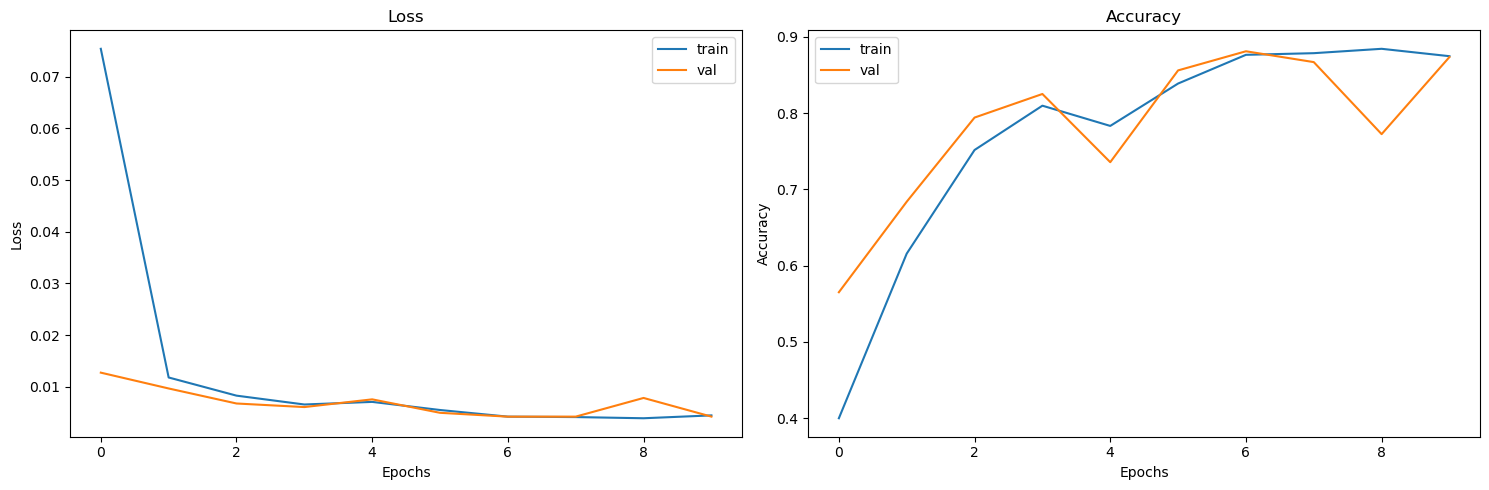

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].set_title("Loss")
axes[0].plot(train_losses, label="train")
axes[0].plot(val_losses, label="val")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot accuracy
axes[1].set_title("Accuracy")
axes[1].plot(train_accuracy, label="train")
axes[1].plot(val_accuracy, label="val")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

Preprocessing

In [ ]:
val_gt_list = [tensor.tolist() for tensor in val_gt]
val_predictions_list = [[int(item) for item in tensor.tolist()] for tensor in val_predictions]

# Flatten the lists of tensors
val_predictions_flat = [item for sublist in val_predictions_list for item in sublist]
val_gt_flat = [item for sublist in val_gt for item in sublist]

# Convert to numpy arrays for easier manipulation
val_predictions_flat = np.array(val_predictions_flat)
val_gt_flat = np.array(val_gt_flat)

Calculate TP, FP, TN, FN and plot confusion matrix.

True Positives: {0: 249, 1: 234, 2: 286, 3: 276}
False Positives: {0: 83, 1: 33, 2: 15, 3: 20}
True Negatives: {0: 824, 1: 852, 2: 886, 3: 875}
False Negatives: {0: 40, 1: 77, 2: 9, 3: 25}


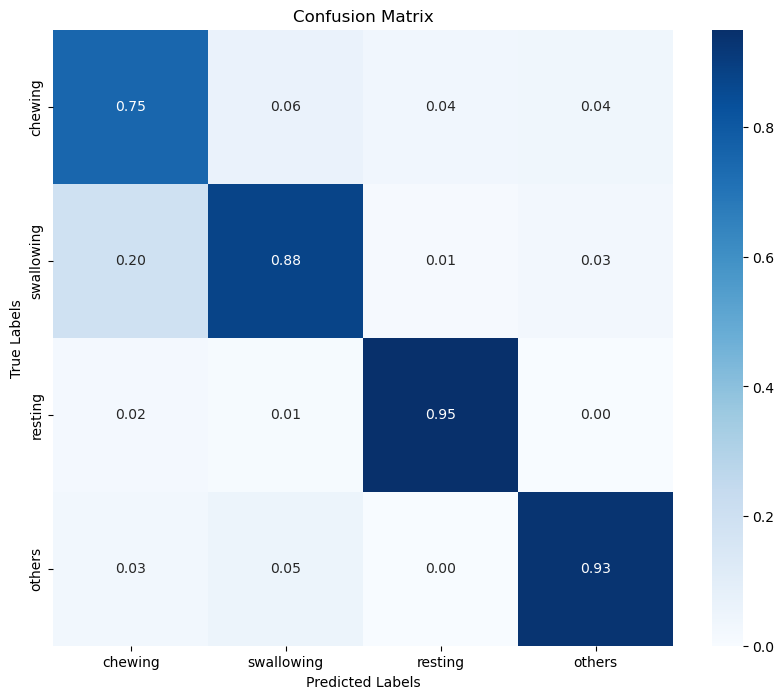

In [ ]:
# Get the unique classes
classes = np.unique(val_gt_flat)

# Initialize dictionaries to store TP and FP for each class
tp = {cls: 0 for cls in classes}
fp = {cls: 0 for cls in classes}

# Calculate TP and FP for each class
for cls in classes:
    tp[cls] = np.sum((val_predictions_flat == cls) & (val_gt_flat == cls))
    fp[cls] = np.sum((val_predictions_flat == cls) & (val_gt_flat != cls))

print("True Positives:", tp)
print("False Positives:", fp)

# Initialize dictionaries to store TN and FN for each class
tn = {cls: 0 for cls in classes}
fn = {cls: 0 for cls in classes}

# Calculate TN and FN for each class
for cls in classes:
    tn[cls] = np.sum((val_predictions_flat != cls) & (val_gt_flat != cls))
    fn[cls] = np.sum((val_predictions_flat != cls) & (val_gt_flat == cls))

print("True Negatives:", tn)
print("False Negatives:", fn)

# Compute confusion matrix
cm = confusion_matrix(val_gt_flat, val_predictions_flat, labels=classes, normalize='pred')

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['chewing', 'swallowing', 'resting', 'others'], yticklabels=['chewing', 'swallowing', 'resting', 'others'], ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

Calculate precision, recall, F1 and accuracy averaged over all classes.

In [14]:
# Calculate metrics
precision = precision_score(val_gt_flat, val_predictions_flat, average='macro')
recall = recall_score(val_gt_flat, val_predictions_flat, average='macro')
f1 = f1_score(val_gt_flat, val_predictions_flat, average='macro')
accuracy = accuracy_score(val_gt_flat, val_predictions_flat)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.8772507599428163
Recall: 0.8751095795207111
F1 Score: 0.8739939019166719
Accuracy: 0.8737458193979933
